In [ ]:
import tensorflow as tf
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import umap
from common.models import AutoEncoder, Encoder, Decoder, MultiHeadAutoEncoder


In [2]:
ad_model_path = Path("..") / "anomaly_detection" / 'day4_44_model.h5'
triplet_loss_model_path = Path("..") / 'triplet_loss' / 'models' / 'day4_46_model'

data_dir = Path('..') / 'data' / 'ProcessedMixed'
mal_dir =  Path('..') / 'data' / 'Processed' / f'Malware'

In [3]:
ad_model = tf.keras.models.load_model(ad_model_path)
triplet_model = tf.keras.models.load_model(triplet_loss_model_path, custom_objects={'AutoEncoder': AutoEncoder, 'Encoder': Encoder, "Decoder": Decoder})
triplet_encoder = triplet_model.layers[3].encoder

2022-10-14 12:25:46.431101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib
2022-10-14 12:25:46.431141: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 12:25:46.431171: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pjanata-ntb): /proc/driver/nvidia/version does not exist
2022-10-14 12:25:46.431988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
while len(ad_model.layers) > 6:
    ad_model.pop()
ad_model.summary()
ad_encoder = ad_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
Total params: 2,054
Trainable params: 2,054
Non-trainabl

In [5]:
ad_encoder.add(k.)

In [54]:
input_layers = triplet_model.layers.pop()

In [58]:
def load_all_ben_data():
    datasets = []
    for client_dir in data_dir.iterdir():
        if "Malware" in client_dir.name:
            continue
        for day_dir in client_dir.iterdir():
            file = day_dir / 'comb_features.csv'
            datasets.append(pd.read_csv(file))
    X = pd.concat(datasets)
    X.drop_duplicates(inplace=True)
    y = X[['label', 'detailedlabel']]
    X.drop(["ssl_ratio", "self_signed_ratio", "SNI_equal_DstIP", "ratio_certificate_path_error", "ratio_missing_cert_in_cert_path", 'label', 'detailedlabel'], axis=1, inplace=True)

    return X, y

def load_all_mal_data():
    datasets = []
    for i, malware_dir in enumerate(sorted(mal_dir.iterdir()), start=1):
        for day_dir in malware_dir.iterdir():
            file = day_dir / 'comb_features.csv'
            if file.exists():
                df = pd.read_csv(file)
                df['label'] = 'Malicius'
                df['detailedlabel'] = malware_dir.name.replace('CTU-Malware-Capture-Botnet', 'botnet')
                datasets.append(df)
    X = pd.concat(datasets)
    X.drop_duplicates(inplace=True)
    y = X[['label', 'detailedlabel']]
    X.drop(["ssl_ratio", "self_signed_ratio", "SNI_equal_DstIP", "ratio_certificate_path_error", "ratio_missing_cert_in_cert_path", 'label', 'detailedlabel'], axis=1, inplace=True)

    return X, y

def load_all_data():
    X, y = load_all_ben_data()
    X_mal, y_mal = load_all_mal_data()
    return pd.concat((X, X_mal)), pd.concat((y, y_mal))

X, y = load_all_data()
labels = ['ben'] + [x.name.replace('CTU-Malware-Capture-Botnet', 'mal') for x in sorted(mal_dir.iterdir())]

In [170]:
# ben_X = X[(y==0).values]
# ad_pred = ad_encoder.predict(ben_X)
# embedding = umap.UMAP().fit(ad_pred)
# ad_embedded = embedding.transform(ad_encoder.predict(X))
ad_embedded = umap.UMAP(n_components=3).fit_transform(ad_encoder.predict(X))

1138/1138 [==============================] - 6s 5ms/step


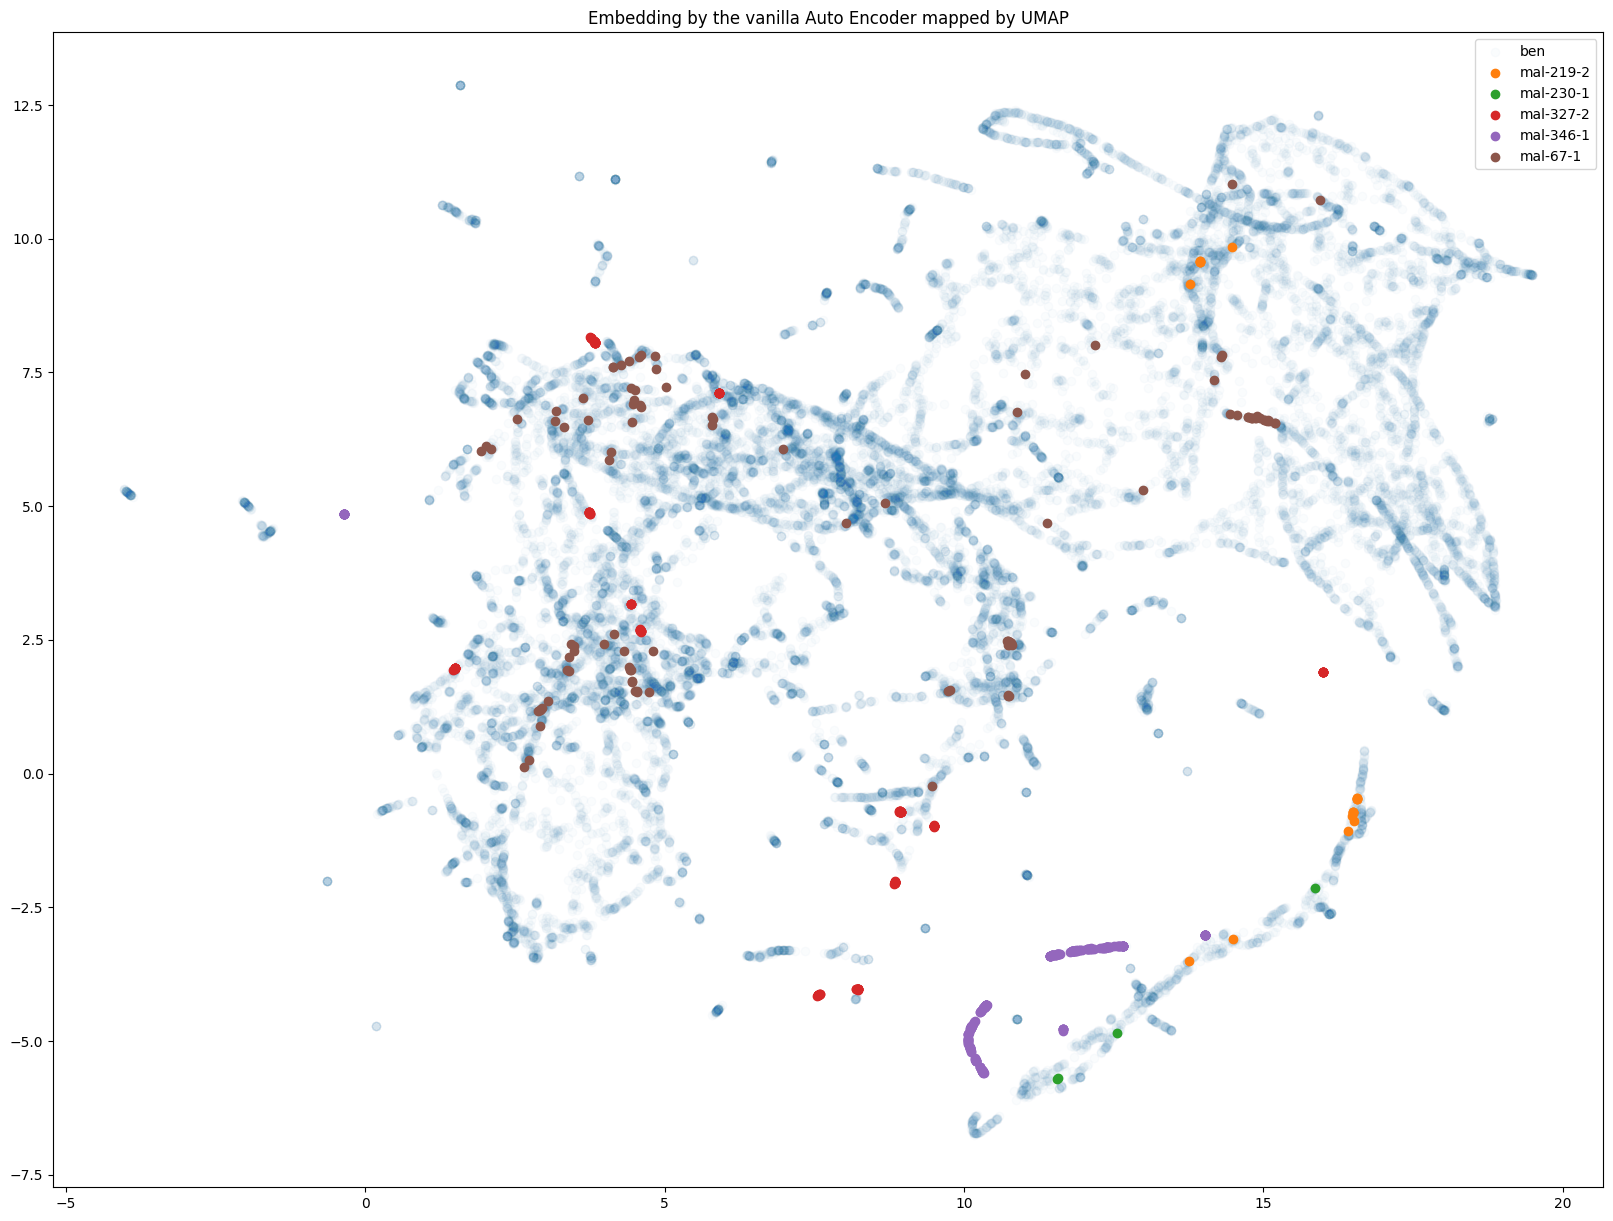

In [174]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot()#(projection='3d')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for cls in sorted(set(y)):
    ax.scatter(ad_embedded[y==cls, 0], ad_embedded[y==cls, 1], c=colors[cls], label=labels[cls], alpha=0.02 if cls==0 else 1)

ax.legend()
plt.title("Embedding by the vanilla Auto Encoder mapped by UMAP")
plt.savefig('embedding_vanilla_ae.png')
plt.show()

In [60]:
# ben_X = X[(y==0).values]
# triplet_pred = triplet_encoder(ben_X.values)
# embedding = umap.UMAP().fit(triplet_pred)
# triplet_embedded = embedding.transform(triplet_encoder(X.values))
triplet_embedded =  umap.UMAP(n_components=2).fit_transform(triplet_encoder(X.values))

In [61]:
len(X), len(y)

(36623, 36623)

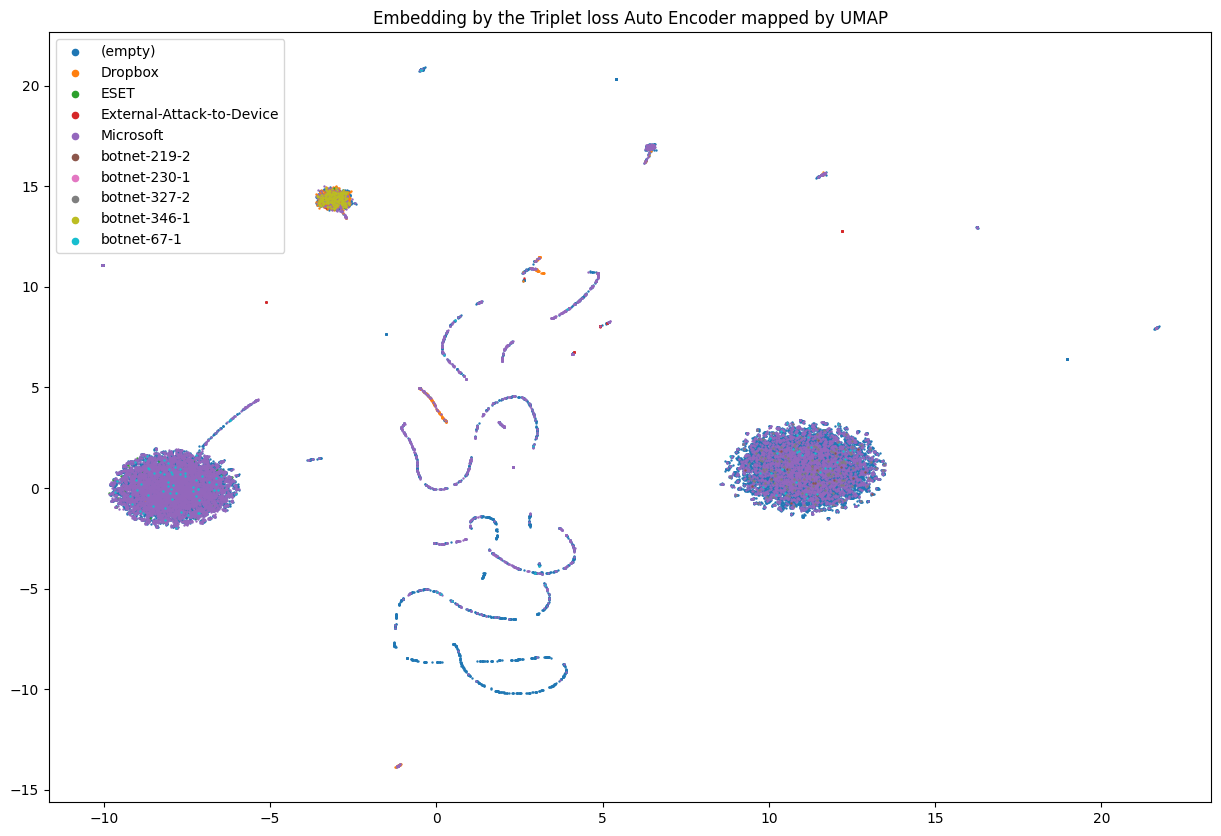

In [78]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()#(projection='3d')
classes = sorted(y.detailedlabel.unique())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# ax.scatter(triplet_embedded[:, 0], triplet_embedded[:, 1], label=y['detailedlabel'])
for i, cls in enumerate(classes):
    x = triplet_embedded[y.detailedlabel==cls, 0]
    ax.scatter(triplet_embedded[y.detailedlabel==cls, 0], triplet_embedded[y.detailedlabel==cls, 1], c=colors[i], label=cls, alpha=1, s=0.5)
legend = ax.legend()
for legend_handle in legend.legendHandles:
    legend_handle._sizes = [20]
plt.title("Embedding by the Triplet loss Auto Encoder mapped by UMAP")
plt.savefig('embedding_triplet_loss_ae.png')
plt.show()

In [73]:
legend.legendHandles[0]._sizes = [10]

TypeError: len() of unsized object

<AxesSubplot: xlabel='date', ylabel='weight'>

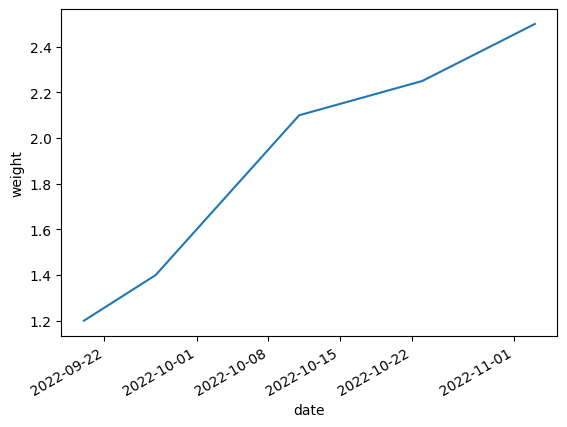

In [4]:
data = {
    '2022-09-20': 1.2,
    '2022-09-27': 1.4,
    '2022-10-01': 1.6,
    '2022-10-05': 1.8,
    '2022-10-11': 2.1,
    '2022-10-23': 2.25,
    '2022-11-03': 2.5,
}
df = pd.Series(data)
series = pd.Series(data)
series.index = pd.to_datetime(series.index)
series.plot(xlabel='date', ylabel='weight')